# Generating marked dataset of documents

In [21]:
pip install opencv-python


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
import random
import subprocess
import os
import re
import cv2
import numpy as np
from pdf2image import convert_from_path
import pytesseract
from PIL import Image, ImageDraw
from collections import defaultdict
import matplotlib.pyplot as plt 

### Generating latex base

In [6]:
def generate_latex_document(num_fields, output_file="document.tex"):
    with open("doc_parts/headers.txt", "r") as f:
        headers = f.read().split("\n\n\n")

    latex_document = random.choice(headers)


    for i in range(random.randint(1, 3)):
        block_length = random.randint(20, 80)
        random_text = " ".join(["word" for _ in range(block_length)])
        latex_document += "\n\n"
        latex_document += f"\\paragraph{{Block {i+1}}} {random_text}"

    latex_document += "\n"
    
    if random.random() > 0.1:
        with open("doc_parts/input_fields.txt", "r") as f:
            input_field_blocks = f.read().split("\n\n\n")

        for _ in range(num_fields):
            latex_document += "\n" + random.choice(input_field_blocks)


    with open("doc_parts/signature_blocks.txt", "r") as f:
        signature_blocks = f.read().split("\n\n\n")

    latex_document += "\n" + random.choice(signature_blocks)

    latex_document += "\n \\end{document}"

    with open(output_file, "w") as f:
        f.write(latex_document)

### Converting Latex to PDF

In [7]:
def compile_to_pdf(latex_file, output_folder=""):
    try:
        base_name = os.path.splitext(os.path.basename(latex_file))[0]
        pdf_file = os.path.join(output_folder, f"{base_name}.pdf")

        subprocess.run(
            [
                "pdflatex",
                "-output-directory", output_folder,
                "-interaction=nonstopmode",
                "-halt-on-error",
                "-jobname", base_name,
                "-output-format=pdf",
                "--shell-escape",
                latex_file
            ],
            check=True,
            stdout=subprocess.DEVNULL,  # Suppress console output
            stderr=subprocess.DEVNULL
        )

        # Clean up auxiliary files
        for ext in [".log", ".aux", ".out"]:
            aux_file = os.path.join(output_folder, f"{base_name}{ext}")
            if os.path.exists(aux_file):
                os.remove(aux_file)

        return pdf_file

    except subprocess.CalledProcessError as e:
        print(f"Error compiling LaTeX file: {latex_file} {e}")
        return None


In [8]:
def convert_pdf_to_jpg(pdf_file, exit_folder, dpi=300, format="JPEG"):
    os.makedirs(exit_folder, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(pdf_file))[0]
    image_path = os.path.join(exit_folder, f"{base_name}.{format.lower()}")

    image = convert_from_path(pdf_file, dpi=dpi)[0]
    image.save(image_path, format)
    return image_path

### Exctracting bbox and input fields

In [9]:
def extract_items_with_coordinates(image_path, output_txt_folder):
    os.makedirs(output_txt_folder, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    txt_file = os.path.join(output_txt_folder, f"{base_name}.txt")
    image = Image.open(image_path).convert("L")

    data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

    items = []
    detected_input_fields = []
    detected_checkboxes = []

    def is_garbage_text(text):
        if len(text) <= 3 and not re.match(r"^[A-Z0-9]+$", text):
            return True
        return False

    for i in range(len(data["text"])):
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        text = data["text"][i].strip()
        if text and not is_garbage_text(text):
            items.append({"x": x, "y": y, "width": w, "height": h, "text": text, "type": "word"})

    width, height = image.size
    pixel_data = image.load()

    for y in range(height):
        line_start = None
        for x in range(width):
            pixel = pixel_data[x, y]
            if pixel < 100:
                if line_start is None:
                    line_start = x
            elif line_start is not None:
                line_length = x - line_start

                if line_length > 100:
                    is_near_text = False
                    for word in items:
                        wx1, wy1 = word["x"], word["y"]
                        wx2, wy2 = wx1 + word["width"], wy1 + word["height"]
                        if abs(y - wy1) < 10 and not (line_start > wx2 or x < wx1):
                            is_near_text = True
                            break

                    if not is_near_text:
                        detected_input_fields.append({
                            "x": line_start, "y": y, "width": line_length,
                            "height": 2, "text": "", "type": "input_field"
                        })
                line_start = None

    grouped_by_y = defaultdict(list)
    y_tolerance = 5

    for field in detected_input_fields:
        found_group = False
        for key in grouped_by_y:
            if abs(key - field["y"]) <= y_tolerance:
                grouped_by_y[key].append(field)
                found_group = True
                break
        if not found_group:
            grouped_by_y[field["y"]].append(field)

    unique_input_fields = []
    for y_group, segments in grouped_by_y.items():
        segments = sorted(segments, key=lambda s: s["x"])
        merged = []
        current = segments[0]
        max_gap = 100
        for seg in segments[1:]:
            gap = seg["x"] - (current["x"] + current["width"])
            if gap <= max_gap:
                current["width"] = max(current["width"], seg["x"] + seg["width"] - current["x"])
            else:
                merged.append(current)
                current = seg
        merged.append(current)
        unique_input_fields.extend(merged)

    def overlaps_with_words(box, word_items, margin=5):
        for word in word_items:
            wx1, wy1 = word["x"], word["y"]
            wx2, wy2 = wx1 + word["width"], wy1 + word["height"]
            bx1, by1 = box["x"] - margin, box["y"] - margin
            bx2, by2 = box["x"] + box["width"] + margin, box["y"] + box["height"] + margin
            if not (bx2 < wx1 or bx1 > wx2 or by2 < wy1 or by1 > wy2):
                return True
        return False

    # === Step 5: Detect checkboxes via contours ===
    cv_image = np.array(image)
    _, binary = cv2.threshold(cv_image, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(contour)

        if 0.8 <= aspect_ratio <= 1.2 and 10 <= w <= 40 and 10 <= h <= 40 and area > 100:
            box = {"x": x, "y": y, "width": w, "height": h, "text": "", "type": "checkbox"}

            if not overlaps_with_words(box, items) and not any(
                abs(box["x"] - cb["x"]) < 5 and abs(box["y"] - cb["y"]) < 5 for cb in detected_checkboxes
            ):
                detected_checkboxes.append(box)


    short_caps_words = []
    for i in range(10, len(data["text"])):
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        text = data["text"][i].strip()
        if len(text) <= 3 and re.fullmatch(r"[A-Z]+", text):
            short_caps_words.append({
                "x": x, "y": y, "width": w, "height": h,
                "text": "", "type": "checkbox"})

    with open(txt_file, "w") as f:
        for item in items + unique_input_fields + detected_checkboxes + short_caps_words: 
            f.write(f"{item['x']} {item['y']} {item['width']} {item['height']} {item['text']} {item['type']}\n")

    return txt_file


In [37]:
extract_items_with_coordinates('doc_parts/jpg_docs/document_9.jpeg', 'doc_parts/')

'doc_parts/document_9.txt'

In [10]:
def print_progress(current, total, prefix='', postfix='files generated'):
    print(f"\r{prefix} {current}/{total} {postfix}", end='', flush=True)

def generate_documents(total_docs=10):
    latex_docs_folder = "doc_parts/latex_docs"
    created_docs_folder = "doc_parts/created_docs"
    jpg_output_folder = "doc_parts/jpg_docs"
    
    os.makedirs(latex_docs_folder, exist_ok=True)
    os.makedirs(created_docs_folder, exist_ok=True)
    os.makedirs(jpg_output_folder, exist_ok=True)

    print("🔄 Generating LaTeX and compiling to JPEG...")
    for i in range(total_docs):
        num_fields = random.randint(1, 2)
        latex_file = os.path.join(latex_docs_folder, f"document_{i + 1}.tex")
        generate_latex_document(num_fields=num_fields, output_file=latex_file)
        pdf_file = compile_to_pdf(latex_file, created_docs_folder)
        if pdf_file:
            convert_pdf_to_jpg(pdf_file, jpg_output_folder)
        print_progress(i + 1, total_docs, prefix="📄 Documents created:", postfix='documents')

    print("\n✅ Finished generating documents.")

In [11]:
def extract_all_annotations(total_docs=10):
    jpg_output_folder = "doc_parts/jpg_docs"
    txt_output_folder = "doc_parts/txt_docs"

    os.makedirs(txt_output_folder, exist_ok=True)

    print("🔍 Extracting annotations from JPEG files...")
    for i in range(total_docs):
        filename = f"document_{i + 1}.jpeg"
        image_path = os.path.join(jpg_output_folder, filename)
        if os.path.exists(image_path):
            extract_items_with_coordinates(image_path, txt_output_folder)
        print_progress(i + 1, total_docs, prefix="✏️ Annotations extracted:")

    print("\n✅ All annotations saved.")

In [34]:
generate_documents(total_docs=2000)

🔄 Generating LaTeX and compiling to JPEG...
📄 Documents created: 2000/2000 documents
✅ Finished generating documents.


In [35]:
extract_all_annotations(total_docs=2000)

🔍 Extracting annotations from JPEG files...
✏️ Annotations extracted: 2000/2000 files generated
✅ All annotations saved.


In [53]:
def convert_to_yolov10_format(custom_txt_path, image_path, output_folder, class_map=None, no_words=False):
    if class_map is None:
        if not no_words:
            class_map = {"word": 0, "input_field": 1, "checkbox": 2}
        else:
            class_map = {"word": 2, "input_field": 0, "checkbox": 1}
            
    os.makedirs(output_folder, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(custom_txt_path))[0]
    output_path = os.path.join(output_folder, f"{base_name}.txt")

    with Image.open(image_path) as img:
        img_width, img_height = img.size

    items = []
    word_heights = []

    with open(custom_txt_path, "r") as infile:
        for line in infile:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            x, y, w, h = map(int, parts[:4])
            obj_type = parts[-1]

            items.append((x, y, w, h, obj_type))

            if obj_type == "word":
                word_heights.append(h)

    avg_word_height = int(sum(word_heights) / len(word_heights)) if word_heights else 20

    with open(output_path, "w") as outfile:
        for x, y, w, h, obj_type in items:
            class_id = class_map.get(obj_type, -1)
            if class_id == -1:
                continue

            if obj_type == "input_field":
                new_h = avg_word_height
                bottom_y = y + h
                y = bottom_y - new_h
                h = new_h

            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            norm_w = w / img_width
            norm_h = h / img_height

            if no_words:
                if class_id != 2:
                    outfile.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")
            else:
                outfile.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")

    return output_path


In [54]:
def convert_annotations_to_YOLO(total_docs=10, no_words=False, output_folder = "doc_parts/YOLO_docs"):
    jpg_input_folder = "doc_parts/jpg_docs"
    txt_input_folder = "doc_parts/txt_docs"

    os.makedirs(output_folder, exist_ok=True)

    print("🔍 Converting custom .txt files to YOLOv10 format...")
    for i in range(total_docs):
        
        image_name = f"document_{i + 1}.jpeg"
        image_path = os.path.join(jpg_input_folder, image_name)

        layout_name = f"document_{i + 1}.txt"
        layout_path = os.path.join(txt_input_folder, layout_name)
        
        if os.path.exists(image_path):
            convert_to_yolov10_format(layout_path, image_path, output_folder, no_words=no_words)
        print_progress(i + 1, total_docs, prefix="✏️ Files converted:", postfix='files')

    print("\n✅ Finished converting.")

In [50]:
convert_annotations_to_YOLO(total_docs = 2000)

🔍 Converting custom .txt files to YOLOv10 format...
✏️ Files converted: 2000/2000 files
✅ Finished converting.


In [44]:
def visualize_yolo_labels(yolo_txt_path, image_path, class_names=None, figsize=(20, 20)):
    """
    Visualize YOLO annotations with class-based colors.

    Red: input_field (class_id = 1)  
    Yellow: checkbox (class_id = 2)  
    Green: other classes
    """
    color_map = {
        1: "red",       # input_field
        2: "yellow"     # checkbox
    }

    with Image.open(image_path) as img:
        draw = ImageDraw.Draw(img)
        img_width, img_height = img.size

        with open(yolo_txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue

                class_id, x_center, y_center, w, h = map(float, parts)
                class_id = int(class_id)

                # Convert normalized to pixel values
                x_center *= img_width
                y_center *= img_height
                w *= img_width
                h *= img_height

                x1 = x_center - w / 2
                y1 = y_center - h / 2
                x2 = x_center + w / 2
                y2 = y_center + h / 2

                label = class_names[class_id] if class_names and class_id in class_names else str(class_id)
                color = color_map.get(class_id, "green")

                draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
                draw.text((x1, y1 - 10), label, fill=color)

        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.title("YOLOv10 Visualized Annotations")
        plt.show()


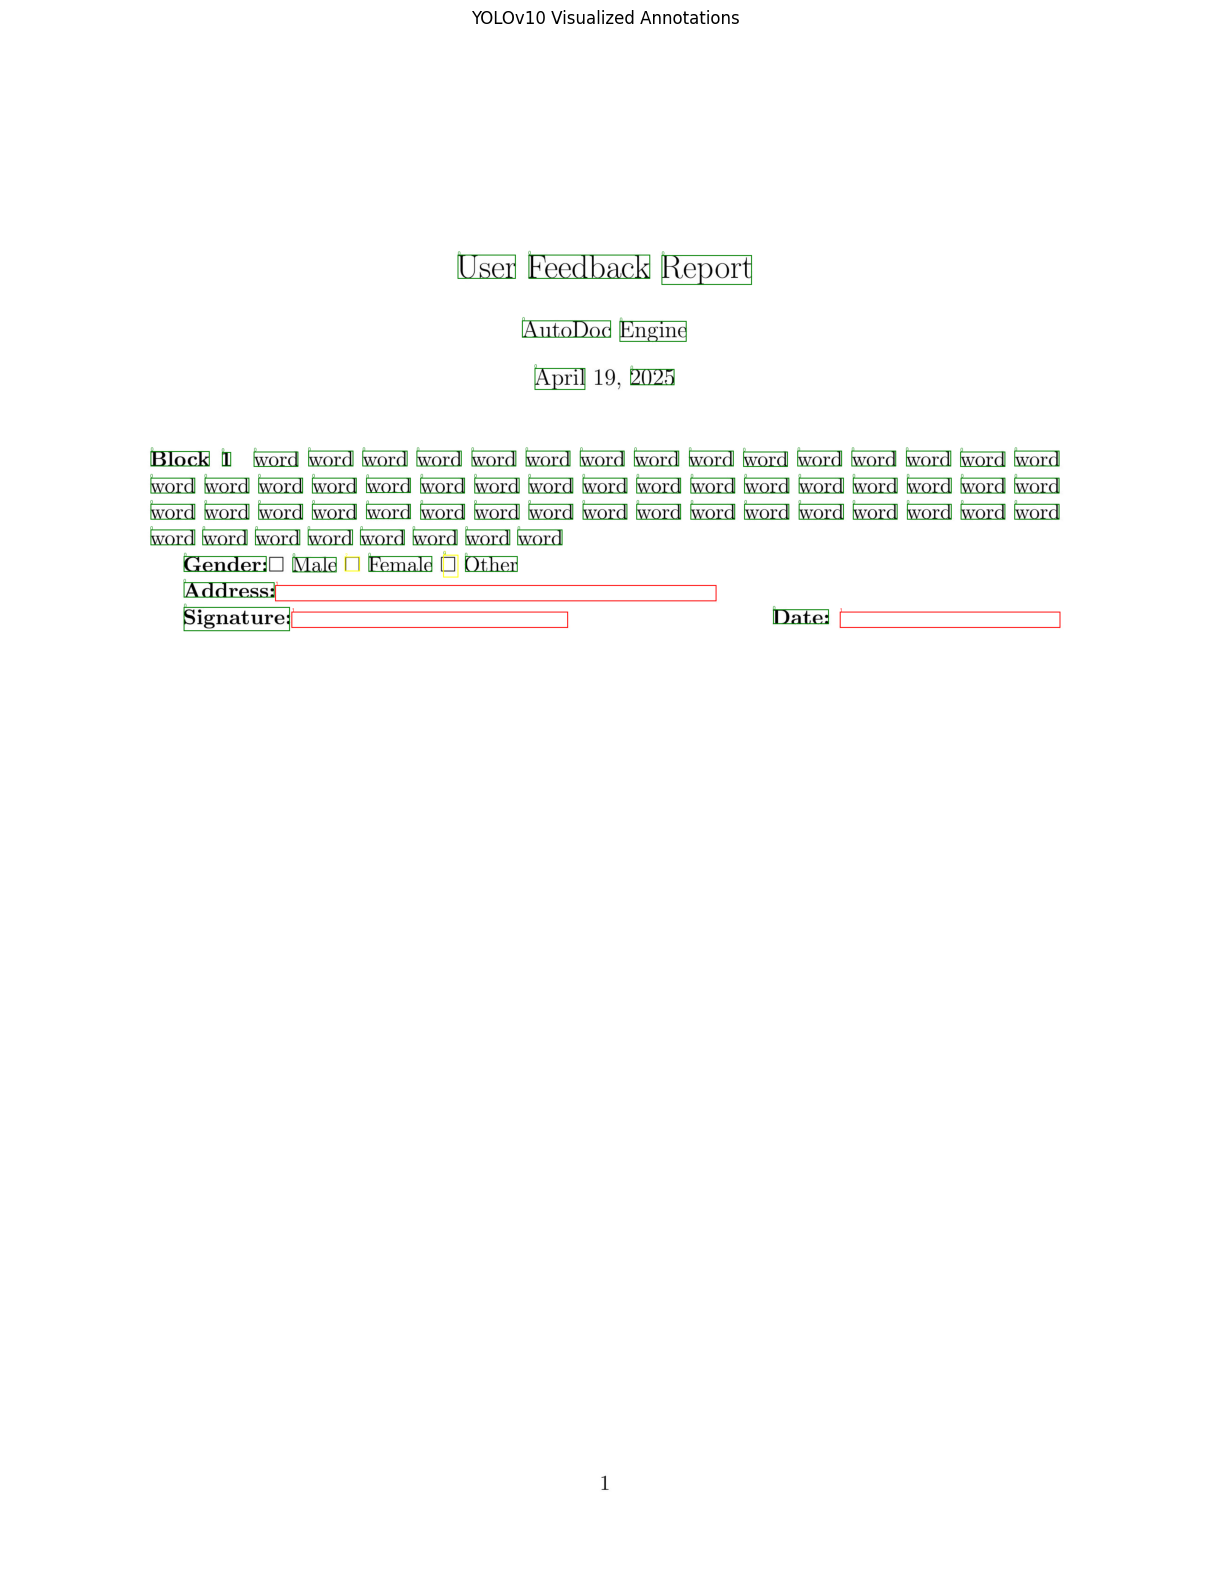

In [58]:
n = 1094

visualize_yolo_labels(
    yolo_txt_path = f"doc_parts/YOLO_docs/document_{n}.txt",
    image_path = f"doc_parts/jpg_docs/document_{n}.jpeg")

In [55]:
convert_annotations_to_YOLO(total_docs = 2000, no_words = True, output_folder = "doc_parts/YOLO_docs_no_words")

🔍 Converting custom .txt files to YOLOv10 format...
✏️ Files converted: 2000/2000 files
✅ Finished converting.
